In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect('C:/Users/DELL/Desktop/appliedAi/Data set/Amazon/database.sqlite') 
filteredData = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con)
#filteredData=filteredData.iloc[0:3000,:]
#filteredData.shape               
dfScore=filteredData['Score']


def convertPositiveNegative(x):
    if x < 3:
        return 'negative'
    return 'positive'
dfPositiveNegative=dfScore.map(convertPositiveNegative)




filteredData['Score']=dfPositiveNegative


In [2]:
sorted_data=filteredData.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [3]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [4]:
(final['Id'].size*1.0)/(filteredData['Id'].size*1.0)*100

69.25890143662969

In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [6]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import nltk
nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [8]:
final['CleanedText']=final_string


In [9]:
final.head(3) #below the processed review can be seen in the CleanedText Column 
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [10]:
final=final.sort_values(by='Time')

In [11]:
final['Score_num']=final.Score.map({'positive':1, 'negative':0})
Y=final['Score_num']

# BOW

In [12]:
final_bow=final.iloc[0:1000,:]

In [13]:
y_bow=final_bow['Score_num']

In [14]:
count_vect_bow=CountVectorizer()
df_vect_bow = count_vect_bow.fit_transform(final_bow['CleanedText'].values)

In [15]:
df_vect_bow_to_dense=df_vect_bow.todense()

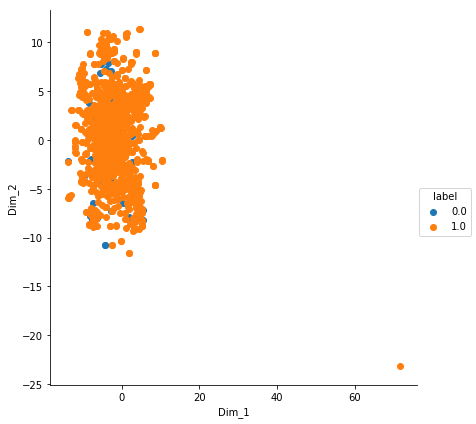

In [16]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(df_vect_bow_to_dense)

tsne_data = np.vstack((tsne_data.T,y_bow)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

import seaborn as sn
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


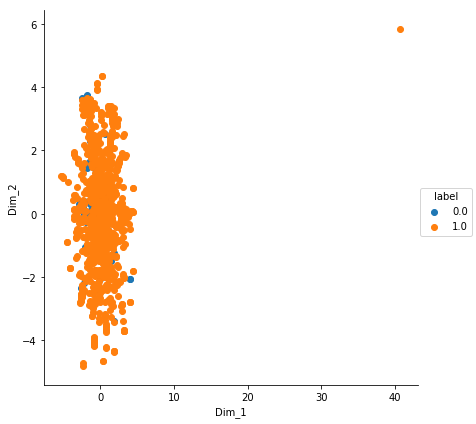

In [17]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=100,n_iter=2000)
tsne_data = model.fit_transform(df_vect_bow_to_dense)

tsne_data = np.vstack((tsne_data.T,y_bow)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

import seaborn as sn
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# tfidf

In [18]:
final_tfidf=final.iloc[0:1000,:]

In [19]:
y_tsne=final_tfidf['Score_num']

In [20]:
count_vect = TfidfVectorizer() #in scikit-learn
df_vect = count_vect.fit_transform(final_tfidf['CleanedText'].values)

In [22]:
df_vect_to_dense=df_vect.todense()

In [23]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(df_vect_to_dense)

In [24]:
tsne_data = np.vstack((tsne_data.T,y_tsne)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

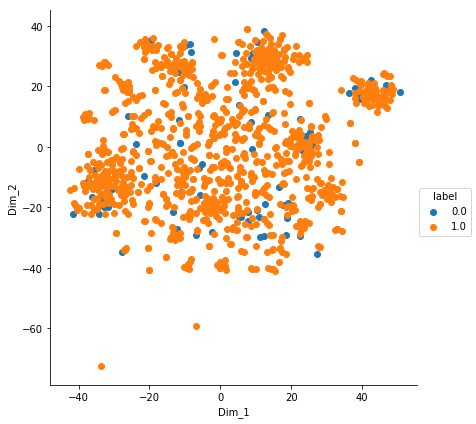

In [25]:
import seaborn as sn
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

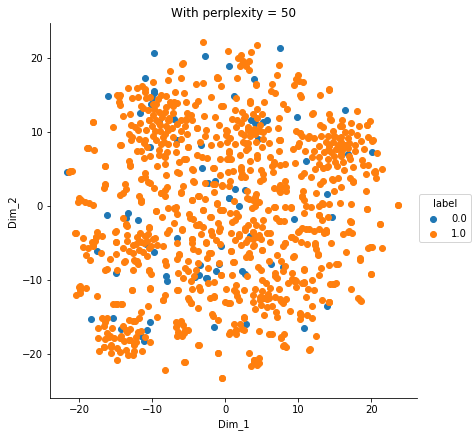

In [26]:
model = TSNE(n_components=2, random_state=0, perplexity=100,n_iter=2000)
tsne_data = model.fit_transform(df_vect_to_dense) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y_tsne)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()


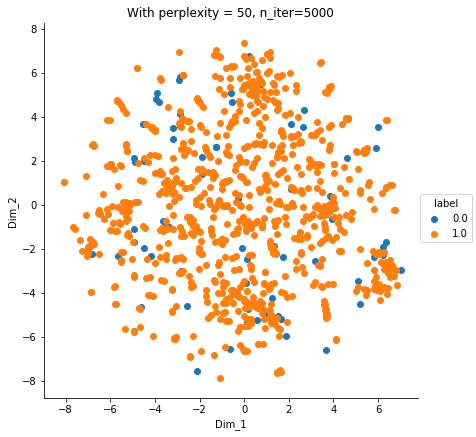

In [27]:
model = TSNE(n_components=2, random_state=0, perplexity=200,  n_iter=300)
tsne_data = model.fit_transform(df_vect_to_dense) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y_tsne)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50, n_iter=5000')
plt.show()

# WORD2VEC

In [28]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [29]:
final_word2vec=final.iloc[0:1000]


In [30]:
y_final_word2vec=final['Score_num'].iloc[0:1000]

In [31]:
y_tsne_word2vec=final_word2vec['Score_num']

In [32]:
final_word2vec['CleanedText']=final_word2vec['CleanedText'].str.decode("utf-8")


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
list_of_train_word2vec=[]
sent=[]


In [35]:
for senten in final_word2vec['CleanedText'].values:
    
    list_of_train_word2vec.append(senten.split())

In [36]:
w2v_model=Word2Vec(list_of_train_word2vec,min_count=5,size=50, workers=4)

In [37]:
words = list(w2v_model.wv.vocab)


In [38]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_train_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)



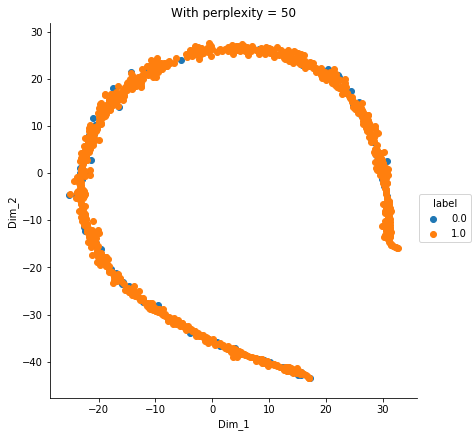

In [39]:
model = TSNE(n_components=2, random_state=0, perplexity=40,n_iter=2000)
tsne_data = model.fit_transform(sent_vectors) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y_tsne_word2vec)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

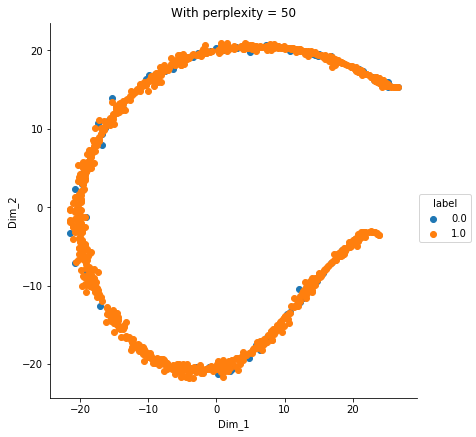

In [40]:
model = TSNE(n_components=2, random_state=0, perplexity=50,n_iter=500)
tsne_data = model.fit_transform(sent_vectors) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y_tsne_word2vec)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

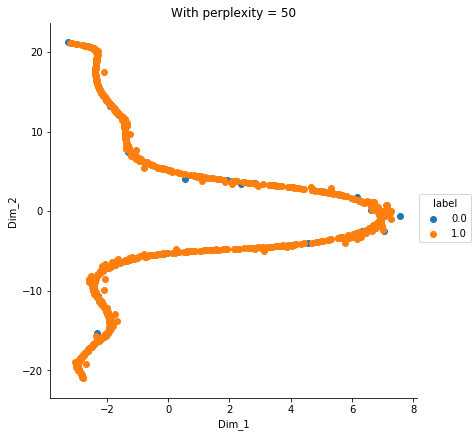

In [41]:
model = TSNE(n_components=2, random_state=0, perplexity=100,n_iter=300)
tsne_data = model.fit_transform(sent_vectors) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y_tsne_word2vec)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()

# tfidfw2vec

In [42]:
tfidf_feat = count_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_train_word2vec: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = df_vect[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


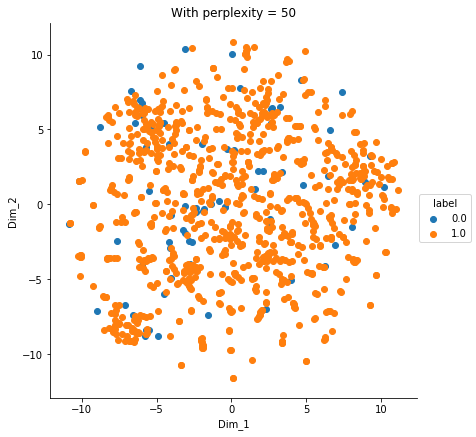

In [43]:
model = TSNE(n_components=2, random_state=0, perplexity=100,n_iter=300)
tsne_data = model.fit_transform(df_vect_to_dense) 

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y_tsne_word2vec)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('With perplexity = 50')
plt.show()